# Les semi-supervised GANs, ou l'art de générer pour mieux classer

Bienvenue dans ce chapitre dédié aux Semi-Supervised Generative Adversarial Networks (SGANs) ! Après avoir exploré le pseudo-labeling (qui se fie aux prédictions confiantes du modèle) et la propagation de labels (qui exploite les similarités entre images via des graphes), on passe à une approche plus 'créative' : utiliser des réseaux adversariaux pour générer de nouvelles données et améliorer la classification.

    Imaginez deux agents en compétition : l'un (le générateur) crée de fausses images pour tromper l'autre (le discriminateur), qui doit non seulement détecter les faux, mais aussi classer les vraies images. Cette 'bataille' permet d'apprendre des représentations riches, même avec peu de labels !

Les SGANs étendent les GANs classiques au semi-supervisé : le discriminateur prédit à la fois 'vrai/faux' et la classe pour les images vraies. Cela permet d'utiliser les données non étiquetées pour renforcer l'apprentissage non supervisé (vrai vs faux), et les étiquetées pour la supervision.

Pourquoi SGAN ? Dans les contextes comme DermaMNIST, où les labels sont rares et coûteux (besoin d'experts médicaux), générer de données variées aide le modèle à mieux généraliser sans ajouter de bruit comme dans le pseudo-labeling.

Compréhension clé de la stratégie SGAN :

    Pour les données étiquetées : On corrige le discriminateur (D) pour prédire la bonne classe (0 à 6) avec une perte supervisée, car on connaît la vérité.
    Pour les données non étiquetées : On corrige D pour les classer comme 'réelles' (somme des probabilités des classes 0 à 6 élevée), sans préciser la classe exacte. C'est une correction 'binaire' : si D les place entre 0 et 6, c'est bien ; si en 7 ('faux'), c'est mal, car ce sont des images réelles.
    Pour les images générées (fausses) : On corrige D pour les classer comme 'fausses' (classe 7). Si D les place en 0 à 6, c'est mal ; l'objectif est de maximiser la probabilité de la classe 7.
    Le générateur (G) veut l'inverse : tromper D en faisant passer ses fausses images pour réelles (probabilités élevées en 0 à 6).

Objectifs pédagogiques :

    🧠 Comprendre les GANs et leur adaptation au semi-supervisé.
    🛠️ Implémenter un Générateur et un Discriminateur simples.
    ⚔️ Mettre en place la boucle d'entraînement adversariale.
    📊 Évaluer le Discriminateur comme classificateur et comparer aux méthodes précédentes.
    🎨 Visualiser les images générées pour voir ce que le modèle 'imagine'.

On réutilise notre setup de DermaMNIST avec 350 images étiquetées (50 par classe). Prêts à lancer la démo ?

## 1. Préparation de l'environnement et des données

On réutilise le code de chargement de DermaMNIST des chapitres précédents. Si vous avez sauté les étapes, exécutez d'abord P1C3 ou P1C4 pour avoir les variables comme `train_dataset`, `labeled_indices`, etc. Ici, on assume qu'elles sont définies.

Rappel de la stratégie SGAN : Les données étiquetées servent à la perte supervisée (correction précise sur la classe connue), les non étiquetées à la perte non supervisée (correction pour 'réel', i.e. classes 0-6), et les générées à renforcer la détection des faux (classe 7).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms
import torchvision.models as models
import medmnist
from medmnist import INFO, Evaluator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Pour la reproductibilité, parce qu'on est des gens sérieux
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Nom du dataset à charger
data_flag = 'dermamnist'
# Récupère les informations spécifiques à ce dataset depuis medmnist
info = INFO[data_flag]

# Ajout de prints pour mieux comprendre le dataset
print(f"Dataset chargé : {data_flag}")

# Extrait le type de tâche (classification, régression, etc.)
task = info['task']
print(f"Type de tâche : {task}")

# Extrait le nombre de canaux des images (3 pour RGB, 1 pour niveaux de gris)
n_channels = info['n_channels']
print(f"Nombre de canaux : {n_channels}")

# Extrait le nombre de classes pour la classification
n_classes = len(info['label'])
print(f"Nombre de classes : {n_classes}")

# Récupère la classe Python spécifique pour ce dataset
DataClass = getattr(medmnist, info['python_class'])

# Transformations: on sépare train/test et on ajoute des augmentations légères pour mieux généraliser
# Normalisation explicite 3 canaux
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Charge les datasets d'entraînement et de test
train_dataset = DataClass(split='train', transform=transform_train, download=True)
test_dataset = DataClass(split='test', transform=transform_test, download=True)

print(f"Taille du jeu d'entraînement : {len(train_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

Dataset chargé : dermamnist
Type de tâche : multi-class
Nombre de canaux : 3
Nombre de classes : 7
Taille du jeu d'entraînement : 7007
Taille du jeu de test : 2005


In [3]:
# On prend tout le set d'entraînement initial
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# Sélectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non étiquetés sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

# Création des Subsets PyTorch
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

print(f"Taille du jeu de données étiqueté : {len(labeled_dataset)}")
print(f"Taille du jeu de données non-étiqueté : {len(unlabeled_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

Taille du jeu de données étiqueté : 350
Taille du jeu de données non-étiqueté : 6657
Taille du jeu de test : 2005


In [4]:
# Loaders pour SGAN (batch_size plus petit pour stabilité)
sgan_labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
sgan_unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 2. Définition des réseaux : générateur et discriminateur

Le **générateur (G)** prend du bruit aléatoire (vecteur de dimension 100) et produit des images 28x28x3.

Le **discriminateur (D)** est une variante de notre SimpleCNN : il sort `n_classes + 1` logits (les n_classes premières pour les classes réelles, la dernière pour 'faux').

Rappel : Lors de l'entraînement, D sera corrigé différemment selon le type d'image :
- Étiquetées : Prédire la classe exacte (0-6).
- Non étiquetées : Prédire 'réel' (somme probs 0-6 élevée).
- Générées : Prédire 'faux' (prob 7 élevée).

In [5]:
# Dimension du bruit
z_dim = 100
device = "cpu"

class Generator(nn.Module):
    def __init__(self, z_dim=z_dim, img_channels=3, img_size=28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size * img_size * img_channels),
            nn.Tanh()  # Sorties entre -1 et 1
        )
        self.img_size = img_size
        self.img_channels = img_channels

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.img_channels, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes + 1)  # +1 pour faux

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instanciation
G = Generator().to(device)
D = Discriminator(n_channels, n_classes).to(device)

# Optimiseurs
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

print('Réseaux SGAN prêts pour la démo !')

Réseaux SGAN prêts pour la démo !


## 3. La boucle d'entraînement adversariale

Lheart des GANs : une boucle où D et G s'affrontent.

Rappel de la stratégie :
- **Pour D sur étiquetées** : Perte supervisée pour prédire la bonne classe (0-6).
- **Pour D sur non étiquetées** : Perte pour prédire 'réel' (somme probs 0-6 élevée).
- **Pour D sur générées** : Perte pour prédire 'faux' (prob 7 élevée).
- **Pour G** : Perte pour tromper D (faire passer les générées pour réelles, somme probs 0-6 élevée).

L'entraînement est alterné. Observez les pertes pour voir l'équilibre.

Entraînement SGAN: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:23<00:00,  2.04s/it]


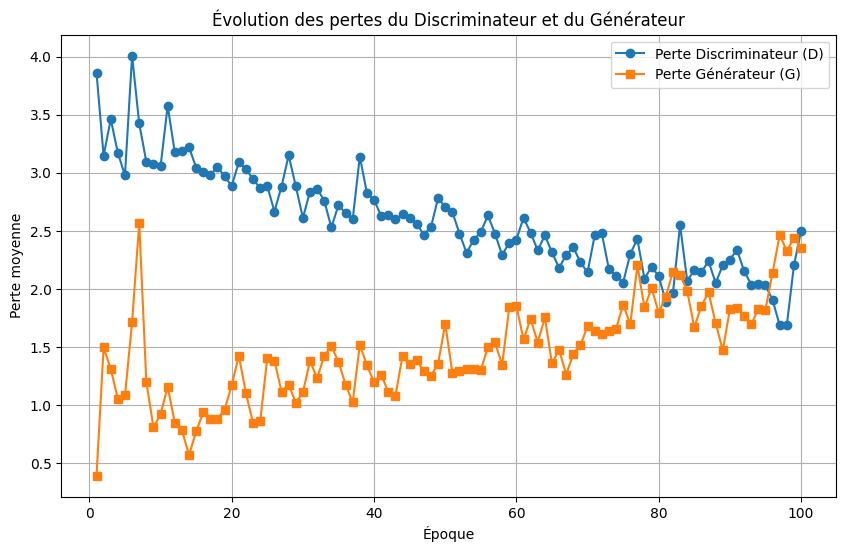

In [6]:
import matplotlib.pyplot as plt

num_epochs = 100  # Ajustez pour la démo (plus = mieux, mais plus long)
supervised_criterion = nn.CrossEntropyLoss()

# Listes pour stocker les pertes moyennes par époque
epoch_d_losses = []
epoch_g_losses = []

for epoch in tqdm(range(num_epochs), desc='Entraînement SGAN'):
    D.train()
    G.train()
    d_losses = []
    g_losses = []

    # Itérateurs pour équilibrer les batches
    labeled_iter = iter(sgan_labeled_loader)
    unlabeled_iter = iter(sgan_unlabeled_loader)

    num_batches = min(len(sgan_labeled_loader), len(sgan_unlabeled_loader))
    for batch_idx in range(num_batches):
        # Données étiquetées
        try:
            labeled_imgs, labels = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(sgan_labeled_loader)
            labeled_imgs, labels = next(labeled_iter)
        labeled_imgs = labeled_imgs.to(device)
        labels = labels.squeeze().long().to(device)

        # Données non étiquetées
        try:
            unlabeled_imgs, _ = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(sgan_unlabeled_loader)
            unlabeled_imgs, _ = next(unlabeled_iter)
        unlabeled_imgs = unlabeled_imgs.to(device)
        batch_size = unlabeled_imgs.size(0)

        # Générer fausses images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)

        # --- Entraîner D ---
        d_optimizer.zero_grad()

        # Supervisé sur réelles étiquetées : corriger pour la bonne classe (0-6)
        real_labeled_logits = D(labeled_imgs)
        d_sup_loss = supervised_criterion(real_labeled_logits[:, :n_classes], labels)

        # Non supervisé sur réelles non étiquetées : corriger pour 'réel' (somme probs 0-6 élevée)
        real_unlabeled_logits = D(unlabeled_imgs)
        real_probs = torch.softmax(real_unlabeled_logits, dim=1)[:, :n_classes].sum(1)
        d_real_unsup_loss = -torch.log(real_probs + 1e-10).mean()

        # Non supervisé sur fausses : corriger pour 'faux' (prob 7 élevée)
        fake_logits = D(fake_imgs.detach())
        fake_probs = torch.softmax(fake_logits, dim=1)[:, n_classes]
        d_fake_unsup_loss = -torch.log(fake_probs + 1e-10).mean()

        d_loss = d_sup_loss + d_real_unsup_loss + d_fake_unsup_loss
        d_loss.backward()
        d_optimizer.step()
        d_losses.append(d_loss.item())

        # --- Entraîner G : corriger pour tromper D (somme probs 0-6 élevée pour fausses) ---
        g_optimizer.zero_grad()

        fake_logits_g = D(fake_imgs)
        g_fake_probs = torch.softmax(fake_logits_g, dim=1)[:, :n_classes].sum(1)
        g_loss = -torch.log(g_fake_probs + 1e-10).mean()

        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.item())

    # Calculer et stocker les pertes moyennes par époque
    epoch_d_losses.append(np.mean(d_losses))
    epoch_g_losses.append(np.mean(g_losses))

# Afficher le graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_d_losses, label='Perte Discriminateur (D)', marker='o')
plt.plot(range(1, num_epochs + 1), epoch_g_losses, label='Perte Générateur (G)', marker='s')
plt.xlabel('Époque')
plt.ylabel('Perte moyenne')
plt.title('Évolution des pertes du Discriminateur et du Générateur')
plt.legend()
plt.grid(True)
plt.show()

## 4. Évaluation et comparaison

Utilisons le Discriminateur comme classificateur : on prend l'argmax sur les n_classes premières sorties.

Rappel : Grâce à la stratégie, D a été corrigé sur les étiquetées (classes exactes), non étiquetées ('réel' vs 'faux'), et générées (détection des faux). Cela devrait améliorer sa performance en classification.

Comparons avec les baselines des chapitres précédents (remplacez les placeholders par vos résultats réels).

In [7]:
def evaluate_sgan(model, test_loader, n_classes):
    model.eval()
    y_true = []
    y_pred = []
    y_score_probs = []  # Pour stocker les probabilités pour l'AUC

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            logits = model(images)[:, :n_classes]  # Logits pour les classes réelles (0 à n_classes-1)
            probs =nn.functional.softmax(logits, dim=1)  # Convertir en probabilités
            preds = torch.argmax(logits, dim=1)  # Prédictions de classe
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy())
            y_score_probs.extend(probs.cpu().numpy())

    # Convertir en arrays NumPy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score_probs = np.array(y_score_probs)

    # Calculer les métriques
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score_probs, multi_class='ovr')  # Utiliser probabilités et 'ovr'
    f1 = f1_score(y_true, y_pred, average='macro')

    return acc, auc, f1

# Appel de la fonction
sgan_acc, sgan_auc, sgan_f1 = evaluate_sgan(D, test_loader, n_classes)
print(f'SGAN - Acc: {sgan_acc:.3f}, F1: {sgan_f1:.3f}, AUC: {sgan_auc:.3f}')

SGAN - Acc: 0.493, F1: 0.299, AUC: 0.831


## 5. Visualisation des images générées

Voyons ce que le Générateur a appris ! On génère quelques images aléatoires.

Rappel : Ces images sont créées pour tromper D, donc si elles ressemblent à des lésions (et forcent D à les classer en 0-6), G a bien fonctionné. Si D les classe en 7, il détecte les faux efficacement.

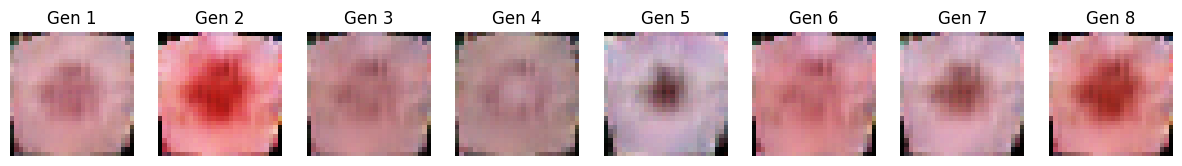

In [8]:
num_gen = 8
z = torch.randn(num_gen, z_dim).to(device)
gen_imgs = G(z).cpu().detach()
gen_imgs = (gen_imgs + 1) / 2  # Dénormaliser [0,1]

fig, axes = plt.subplots(1, num_gen, figsize=(15, 3))
for i in range(num_gen):
    axes[i].imshow(gen_imgs[i].permute(1, 2, 0).numpy())
    axes[i].axis('off')
    axes[i].set_title(f'Gen {i+1}')
plt.show()

## 6. Conclusion et questions pour la suite

Les SGAN démontrent comment la génération adversariale peut enrichir l'apprentissage semi-supervisé en créant de la variété. Rappel de la stratégie : Correction précise sur étiquetées (classes 0-6), 'réel' sur non étiquetées (somme 0-6), 'faux' sur générées (classe 7). Le générateur trompe D pour améliorer les deux.

Si les images générées ressemblent à des lésions cutanées, le modèle a capturé des motifs utiles !

**Questions pour réfléchir :**
1. **Améliorations** : Comment rendre le SGAN conditionnel (cSGAN) pour générer par classe ? Utile pour équilibrer les minoritaires ?
2. **Stabilité** : Les GANs sont instables. Testez avec plus d'époques ou WGAN (Wasserstein loss). Qu'observez-vous ?
3. **Hybride** : Combinez SGAN avec pseudo-labeling : utilisez les fausses images comme non étiquetées supplémentaires.